In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import torchvision
import torch.optim as optim

import numpy as np
from sklearn.manifold import TSNE

import argparse, sys, os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import time
from collections import Counter
import matplotlib.pyplot as plt 

In [2]:
data2 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\session2.npy')
label2 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\label2.npy')
data1 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\session1.npy')
label1 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\label1.npy')
data3 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\session3.npy')
label3 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\label3.npy')

print(data2.shape,label2.shape)
print(data1.shape,label1.shape)

print(Counter(label1))

(23758, 62, 5) (23758,)
(23758, 62, 5) (23758,)
Counter({1: 8190, 2: 7840, 0: 7728})


In [3]:
def get_train_loader(data,label,batch_size,shuffle=True):
    """
    Get train dataloader of source domain or target domain
    :return: dataloader
    """
    tensor_x = torch.Tensor(data) # transform to torch tensor
    tensor_y = torch.Tensor(label)

    my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = torch.utils.data.DataLoader(my_dataset,batch_size=batch_size,shuffle=True,drop_last=True,
                                               num_workers=8, pin_memory=True) # create your dataloader
    
    return my_dataloader

def get_test_loader(data,label,batch_size,shuffle=True):
    """
    Get test dataloader of source domain or target domain
    :return: dataloader
    """
    tensor_x = torch.Tensor(data) # transform to torch tensor
    tensor_y = torch.Tensor(label)

    my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = torch.utils.data.DataLoader(my_dataset,batch_size=batch_size,shuffle=True,drop_last=True,
                                               num_workers=8, pin_memory=True) # create your dataloader
    
    return my_dataloader


def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75

    return optimizer

In [4]:
class GradReverse(torch.autograd.Function):
    """
    Extension of grad reverse layer
    """
    @staticmethod
    def forward(ctx, x, constant):
        ctx.constant = constant
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg() * ctx.constant
        return grad_output, None

    def grad_reverse(x, constant):
        return GradReverse.apply(x, constant)

class Extractor(nn.Module):

    def __init__(self):
        super(Extractor, self).__init__()
        self.conv1 = nn.Conv1d(5, 64, 5, 1) 
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, 5, 1) 
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, 5, 1) 
        self.bn3 = nn.BatchNorm1d(64)
        self.pool = nn.AvgPool1d(5, stride=5)
#         self.pool = nn.MaxPool1d(5, stride=5)
      

    def forward(self, input):
        x = input.permute(0,2,1)
#         print('after permute ',x.shape)  # 64,5,62
        x = F.relu(self.bn1(self.conv1(x))) 
#         print('after CNN1 ',x.shape)    # 64, 64, 58
        x = F.relu(self.bn2(self.conv2(x)))  
#         print('after CNN2 ',x.shape)     #64, 64, 54
#         x = F.avg_pool1d(x,kernel_size=5) 
        x = F.relu(self.bn3(self.conv3(x))) 
        x = self.pool(x)
        
#         print('before fc ',x.shape)    #64, 64, 10
        x = x.view(-1, 64 * 10) 
    
        return x


class Class_classifier(nn.Module):

    def __init__(self):
        super(Class_classifier, self).__init__()
        # self.fc1 = nn.Linear(50 * 4 * 4, 100)
        # self.bn1 = nn.BatchNorm1d(100)
        # self.fc2 = nn.Linear(100, 100)
        # self.bn2 = nn.BatchNorm1d(100)
        # self.fc3 = nn.Linear(100, 10)
        self.fc1 = nn.Linear(64 * 10, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, input):
        # logits = F.relu(self.bn1(self.fc1(input)))
        # logits = self.fc2(F.dropout(logits))
        # logits = F.relu(self.bn2(logits))
        # logits = self.fc3(logits)
        logits = F.relu(self.fc1(input))
        logits = self.fc2(F.dropout(logits))
        logits = F.relu(logits)
        logits = self.fc3(logits)

        return F.log_softmax(logits, 1)

class Domain_classifier(nn.Module):

    def __init__(self):
        super(Domain_classifier, self).__init__()
        # self.fc1 = nn.Linear(50 * 4 * 4, 100)
        # self.bn1 = nn.BatchNorm1d(100)
        # self.fc2 = nn.Linear(100, 2)
        self.fc1 = nn.Linear(64 * 10, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, input, constant):
        input = GradReverse.grad_reverse(input, constant)
        # logits = F.relu(self.bn1(self.fc1(input)))
        # logits = F.log_softmax(self.fc2(logits), 1)
        logits = F.relu(self.fc1(input))
        logits = F.log_softmax(self.fc2(logits), 1)

        return logits


In [5]:
def train(training_mode, feature_extractor, class_classifier, domain_classifier, class_criterion, domain_criterion,
          source_dataloader1, source_dataloader2,  target_dataloader, optimizer, epoch):
    """
    Execute target domain adaptation
    :param training_mode:
    :param feature_extractor:
    :param class_classifier:
    :param domain_classifier:
    :param class_criterion:
    :param domain_criterion:
    :param source_dataloader:
    :param target_dataloader:
    :param optimizer:
    :return:
    """

    # setup models
    feature_extractor.train()
    class_classifier.train()
    domain_classifier.train()

    # steps
    start_steps = epoch * len(source_dataloader1)
    total_steps = 10 * len(source_dataloader1)

    for batch_idx, (sdata1, sdata2, tdata) in enumerate(zip(source_dataloader1, source_dataloader2, target_dataloader)):
        if training_mode == 'dann':
            # setup hyperparameters
            p = float(batch_idx + start_steps) / total_steps
            constant = 2. / (1. + np.exp(-gamma * p)) - 1

            # prepare the data
            input1, label1 = sdata1
            input2, label2 = sdata2
            input3, label3 = tdata
            size = min((input1.shape[0], input2.shape[0], input3.shape[0]))
            input1, label1 = input1[0:size, :, :], label1[0:size]
            input2, label2 = input2[0:size, :, :], label2[0:size]
            input3, label3 = input3[0:size, :, :], label3[0:size]
    
            input1, label1 = Variable(input1.cuda()), Variable(label1.cuda().long())
            input2, label2 = Variable(input2.cuda()), Variable(label2.cuda().long())
            input3, label3 = Variable(input3.cuda()), Variable(label3.cuda().long())

            # setup optimizer
            optimizer = optimizer_scheduler(optimizer, p)
            optimizer.zero_grad()

            # prepare domain labels
           
            source_label1 = Variable(torch.zeros((input1.size()[0])).type(torch.LongTensor).cuda())
            source_label2 = Variable(torch.zeros((input2.size()[0])).type(torch.LongTensor).cuda())
            target_label = Variable(torch.ones((input3.size()[0])).type(torch.LongTensor).cuda())

            # compute the output of source domain and target domain
            src_feature1 = feature_extractor(input1)
            src_feature2 = feature_extractor(input2)
            tgt_feature = feature_extractor(input3)

            # compute the class loss of src_feature
            class_pred1 = class_classifier(src_feature1)
            class_pred2 = class_classifier(src_feature2)
            
            class_loss1 = class_criterion(class_pred1, label1)
            class_loss2 = class_criterion(class_pred2, label2)

            # compute the domain loss of src_feature and target_feature
            tgt_preds = domain_classifier(tgt_feature, constant)
            src_pred1 = domain_classifier(src_feature1, constant)
            src_pred2 = domain_classifier(src_feature2, constant)
            
            tgt_loss = domain_criterion(tgt_preds, target_label)
            src_loss1 = domain_criterion(src_pred1, source_label1)
            src_loss2 = domain_criterion(src_pred2, source_label2)
            
            domain_loss = tgt_loss + src_loss1 + src_loss2
            class_loss = class_loss1 + class_loss2

            loss = class_loss + theta * domain_loss
            loss.backward()
            optimizer.step()

            # print loss
            if (batch_idx + 1) % 60 == 0:
                print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tClass Loss: {:.6f}\tDomain Loss: {:.6f}'.format(
                    batch_idx * len(input2), len(source_dataloader2.dataset),
                    100. * batch_idx / len(source_dataloader2), loss.item(), class_loss.item(),
                    domain_loss.item()
                ))
                
                total_loss.append(loss.item())
                c_loss.append( class_loss.item())
                d_loss.append(domain_loss.item())


In [6]:
def test(feature_extractor, class_classifier, domain_classifier, source_dataloader1, source_dataloader2, target_dataloader):
    """
    Test the performance of the model
    :param feature_extractor: network used to extract feature from target samples
    :param class_classifier: network used to predict labels
    :param domain_classifier: network used to predict domain
    :param source_dataloader: test dataloader of source domain
    :param target_dataloader: test dataloader of target domain
    :return: None
    """
    # setup the network
    feature_extractor.eval()
    class_classifier.eval()
    domain_classifier.eval()
    source_correct1 = 0.0
    source_correct2 = 0.0
    target_correct = 0.0
    domain_correct = 0.0
    tgt_correct = 0.0
    src_correct1 = 0.0
    src_correct2 = 0.0

    for batch_idx, sdata in enumerate(source_dataloader1):
        # setup hyperparameters
        p = float(batch_idx) / len(source_dataloader1)
        constant = 2. / (1. + np.exp(-10 * p)) - 1.

        input1, label1 = sdata
        input1, label1 = Variable(input1.cuda()), Variable(label1.cuda().long())
        src_labels = Variable(torch.zeros((input1.size()[0])).type(torch.LongTensor).cuda())

        output1 = class_classifier(feature_extractor(input1))
        pred1 = output1.data.max(1, keepdim = True)[1]
        source_correct1 += pred1.eq(label1.data.view_as(pred1)).cpu().sum()

        src_preds = domain_classifier(feature_extractor(input1), constant)
        src_preds = src_preds.data.max(1, keepdim= True)[1]
        src_correct1 += src_preds.eq(src_labels.data.view_as(src_preds)).cpu().sum()
        
    for batch_idx, sdata in enumerate(source_dataloader2):
        # setup hyperparameters
        p = float(batch_idx) / len(source_dataloader2)
        constant = 2. / (1. + np.exp(-10 * p)) - 1.

        input2, label2 = sdata
        input2, label2 = Variable(input2.cuda()), Variable(label2.cuda().long())
        src_labels = Variable(torch.zeros((input2.size()[0])).type(torch.LongTensor).cuda())

        output2 = class_classifier(feature_extractor(input2))
        pred2 = output2.data.max(1, keepdim = True)[1]
        source_correct2 += pred1.eq(label2.data.view_as(pred2)).cpu().sum()

        src_preds = domain_classifier(feature_extractor(input2), constant)
        src_preds = src_preds.data.max(1, keepdim= True)[1]
        src_correct2 += src_preds.eq(src_labels.data.view_as(src_preds)).cpu().sum()

    for batch_idx, tdata in enumerate(target_dataloader):
        # setup hyperparameters
        p = float(batch_idx) / len(target_dataloader)
        constant = 2. / (1. + np.exp(-10 * p)) - 1

        input3, label3 = tdata
        input3, label3 = Variable(input3.cuda()), Variable(label3.cuda().long())
        tgt_labels = Variable(torch.ones((input3.size()[0])).type(torch.LongTensor).cuda())

        output3 = class_classifier(feature_extractor(input3))
        pred3 = output3.data.max(1, keepdim=True)[1]
        target_correct += pred3.eq(label3.data.view_as(pred3)).cpu().sum()

        tgt_preds = domain_classifier(feature_extractor(input3), constant)
        tgt_preds = tgt_preds.data.max(1, keepdim=True)[1]
        tgt_correct += tgt_preds.eq(tgt_labels.data.view_as(tgt_preds)).cpu().sum()

    domain_correct = tgt_correct + src_correct1 + src_correct2

    print('\nSource1 Accuracy: {}/{} ({:.4f}%)\nSource2 Accuracy: {}/{} ({:.4f}%)\nTarget Accuracy: {}/{} ({:.4f}%)\n'
          'Domain Accuracy: {}/{} ({:.4f}%)\n'.
        format(
        source_correct1, len(source_dataloader1.dataset), 100. * float(source_correct1) / len(source_dataloader1.dataset),
        source_correct2, len(source_dataloader2.dataset), 100. * float(source_correct2) / len(source_dataloader2.dataset),
        target_correct, len(target_dataloader.dataset), 100. * float(target_correct) / len(target_dataloader.dataset),
        domain_correct, len(source_dataloader1.dataset) + len(source_dataloader2.dataset) + len(target_dataloader.dataset),
        100. * float(domain_correct) / (len(source_dataloader1.dataset) + len(source_dataloader2.dataset) 
                                        + len(target_dataloader.dataset))
    ))
    acc_list1.append(100. * float(source_correct1) / len(source_dataloader1.dataset))
    acc_list2.append(100. * float(source_correct2) / len(source_dataloader2.dataset))
    acc_list3.append(100. * float(target_correct) / len(target_dataloader.dataset))
    acc_list4.append(100. * float(domain_correct) / (len(source_dataloader1.dataset) + len(source_dataloader2.dataset) 
                                        + len(target_dataloader.dataset)))


In [7]:
def main():

    # prepare the source data and target data
    
    src_train_dataloader1 = get_train_loader(data1,label1,batch_size=batch_size,shuffle=False)
    src_test_dataloader1 = get_test_loader(data1,label1,batch_size=batch_size,shuffle=False)
    src_train_dataloader2 = get_train_loader(data3,label3,batch_size=batch_size,shuffle=False)
    src_test_dataloader2 = get_test_loader(data3,label3,batch_size=batch_size,shuffle=False)
    
    tgt_train_dataloader = get_train_loader(data2,label2,batch_size=batch_size,shuffle=False)
    tgt_test_dataloader = get_test_loader(data2,label2,batch_size=batch_size,shuffle=False)

    # init models
    feature_extractor = Extractor()
    class_classifier = Class_classifier()
    domain_classifier = Domain_classifier()

    feature_extractor.cuda()
    class_classifier.cuda()
    domain_classifier.cuda()

    # init criterions
    class_criterion = nn.NLLLoss()
    domain_criterion = nn.NLLLoss()

    # init optimizer
    optimizer = optim.SGD([
            {'params': feature_extractor.parameters()},
                            {'params': class_classifier.parameters()},
                            {'params': domain_classifier.parameters()}
    ], lr= 0.01, momentum= 0.9)

    for epoch in range(200):
    
        print('Epoch: {}'.format(epoch))
        train('dann', feature_extractor, class_classifier, domain_classifier, class_criterion, domain_criterion,
                    src_train_dataloader1, src_train_dataloader2, tgt_train_dataloader, optimizer, epoch)
        test(feature_extractor, class_classifier, domain_classifier, src_test_dataloader1, src_test_dataloader2, tgt_test_dataloader)

        
total_loss, d_loss, c_loss = [],[],[]
acc_list1, acc_list2, acc_list3, acc_list4 = [],[],[],[]
if __name__ == '__main__':
    gamma = 10
    theta = 1
    batch_size = 48
    time_start=time.time()
    main()
    time_end=time.time()
    print('total run time: (min)',(time_end-time_start)/60.)

Epoch: 0
[1888/23758 (8%)]	Loss: 2.484076	Class Loss: 1.480664	Domain Loss: 1.003412
[3808/23758 (16%)]	Loss: 1.920690	Class Loss: 0.901726	Domain Loss: 1.018965
[5728/23758 (24%)]	Loss: 2.088116	Class Loss: 0.825904	Domain Loss: 1.262211
[7648/23758 (32%)]	Loss: 1.536798	Class Loss: 0.513002	Domain Loss: 1.023796
[9568/23758 (40%)]	Loss: 1.832810	Class Loss: 0.559988	Domain Loss: 1.272822
[11488/23758 (48%)]	Loss: 1.609721	Class Loss: 0.666747	Domain Loss: 0.942974
[13408/23758 (56%)]	Loss: 1.508486	Class Loss: 0.405142	Domain Loss: 1.103345
[15328/23758 (65%)]	Loss: 1.685822	Class Loss: 0.271163	Domain Loss: 1.414658
[17248/23758 (73%)]	Loss: 2.155244	Class Loss: 0.631287	Domain Loss: 1.523958
[19168/23758 (81%)]	Loss: 1.650452	Class Loss: 0.471115	Domain Loss: 1.179337
[21088/23758 (89%)]	Loss: 1.718888	Class Loss: 0.382450	Domain Loss: 1.336438
[23008/23758 (97%)]	Loss: 2.056488	Class Loss: 0.477343	Domain Loss: 1.579145

Source1 Accuracy: 12592.0/23758 (53.0011%)
Source2 Accuracy:

[13408/23758 (56%)]	Loss: 1.923996	Class Loss: 0.006563	Domain Loss: 1.917433
[15328/23758 (65%)]	Loss: 1.912188	Class Loss: 0.002165	Domain Loss: 1.910022
[17248/23758 (73%)]	Loss: 1.913528	Class Loss: 0.000433	Domain Loss: 1.913095
[19168/23758 (81%)]	Loss: 1.914822	Class Loss: 0.012047	Domain Loss: 1.902775
[21088/23758 (89%)]	Loss: 1.936111	Class Loss: 0.019248	Domain Loss: 1.916863
[23008/23758 (97%)]	Loss: 1.906368	Class Loss: 0.002628	Domain Loss: 1.903740

Source1 Accuracy: 23709.0/23758 (99.7938%)
Source2 Accuracy: 7777.0/23758 (32.7342%)
Target Accuracy: 17531.0/23758 (73.7899%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 8
[1888/23758 (8%)]	Loss: 1.885674	Class Loss: 0.000856	Domain Loss: 1.884819
[3808/23758 (16%)]	Loss: 1.917211	Class Loss: 0.005673	Domain Loss: 1.911538
[5728/23758 (24%)]	Loss: 1.995268	Class Loss: 0.064695	Domain Loss: 1.930573
[7648/23758 (32%)]	Loss: 1.913511	Class Loss: 0.000406	Domain Loss: 1.913105
[9568/23758 (40%)]	Loss: 1.910527	Class Loss:


Source1 Accuracy: 23743.0/23758 (99.9369%)
Source2 Accuracy: 7925.0/23758 (33.3572%)
Target Accuracy: 17962.0/23758 (75.6040%)
Domain Accuracy: 47443.0/71274 (66.5642%)

Epoch: 15
[1888/23758 (8%)]	Loss: 1.889343	Class Loss: 0.000465	Domain Loss: 1.888877
[3808/23758 (16%)]	Loss: 1.873474	Class Loss: 0.000271	Domain Loss: 1.873203
[5728/23758 (24%)]	Loss: 1.895617	Class Loss: 0.000271	Domain Loss: 1.895346
[7648/23758 (32%)]	Loss: 1.906145	Class Loss: 0.005667	Domain Loss: 1.900478
[9568/23758 (40%)]	Loss: 1.888110	Class Loss: 0.024379	Domain Loss: 1.863731
[11488/23758 (48%)]	Loss: 1.867652	Class Loss: 0.000983	Domain Loss: 1.866669
[13408/23758 (56%)]	Loss: 1.904886	Class Loss: 0.000467	Domain Loss: 1.904419
[15328/23758 (65%)]	Loss: 1.899709	Class Loss: 0.000739	Domain Loss: 1.898970
[17248/23758 (73%)]	Loss: 1.925955	Class Loss: 0.002497	Domain Loss: 1.923458
[19168/23758 (81%)]	Loss: 1.892264	Class Loss: 0.001115	Domain Loss: 1.891149
[21088/23758 (89%)]	Loss: 1.915546	Class Loss

[9568/23758 (40%)]	Loss: 1.895715	Class Loss: 0.000336	Domain Loss: 1.895379
[11488/23758 (48%)]	Loss: 1.897479	Class Loss: 0.000085	Domain Loss: 1.897394
[13408/23758 (56%)]	Loss: 1.892163	Class Loss: 0.000584	Domain Loss: 1.891580
[15328/23758 (65%)]	Loss: 1.925436	Class Loss: 0.006270	Domain Loss: 1.919167
[17248/23758 (73%)]	Loss: 1.900342	Class Loss: 0.000673	Domain Loss: 1.899668
[19168/23758 (81%)]	Loss: 1.904818	Class Loss: 0.000264	Domain Loss: 1.904554
[21088/23758 (89%)]	Loss: 1.901600	Class Loss: 0.000145	Domain Loss: 1.901455
[23008/23758 (97%)]	Loss: 1.900718	Class Loss: 0.000657	Domain Loss: 1.900061

Source1 Accuracy: 23712.0/23758 (99.8064%)
Source2 Accuracy: 7931.0/23758 (33.3824%)
Target Accuracy: 18269.0/23758 (76.8962%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 23
[1888/23758 (8%)]	Loss: 1.901606	Class Loss: 0.000194	Domain Loss: 1.901412
[3808/23758 (16%)]	Loss: 1.910031	Class Loss: 0.000547	Domain Loss: 1.909484
[5728/23758 (24%)]	Loss: 1.893184	Class Los

[21088/23758 (89%)]	Loss: 1.913757	Class Loss: 0.000164	Domain Loss: 1.913593
[23008/23758 (97%)]	Loss: 1.898350	Class Loss: 0.000354	Domain Loss: 1.897997

Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 8032.0/23758 (33.8076%)
Target Accuracy: 18718.0/23758 (78.7861%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 30
[1888/23758 (8%)]	Loss: 1.904482	Class Loss: 0.000034	Domain Loss: 1.904449
[3808/23758 (16%)]	Loss: 1.917046	Class Loss: 0.000270	Domain Loss: 1.916776
[5728/23758 (24%)]	Loss: 1.908953	Class Loss: 0.000198	Domain Loss: 1.908755
[7648/23758 (32%)]	Loss: 1.912415	Class Loss: 0.000416	Domain Loss: 1.911999
[9568/23758 (40%)]	Loss: 1.910612	Class Loss: 0.000162	Domain Loss: 1.910450
[11488/23758 (48%)]	Loss: 1.909569	Class Loss: 0.000037	Domain Loss: 1.909531
[13408/23758 (56%)]	Loss: 1.912402	Class Loss: 0.000030	Domain Loss: 1.912372
[15328/23758 (65%)]	Loss: 1.908341	Class Loss: 0.000063	Domain Loss: 1.908278
[17248/23758 (73%)]	Loss: 1.912128	Class Loss

[5728/23758 (24%)]	Loss: 1.909362	Class Loss: 0.000015	Domain Loss: 1.909347
[7648/23758 (32%)]	Loss: 1.908961	Class Loss: 0.000052	Domain Loss: 1.908910
[9568/23758 (40%)]	Loss: 1.908601	Class Loss: 0.000026	Domain Loss: 1.908575
[11488/23758 (48%)]	Loss: 1.910039	Class Loss: 0.000073	Domain Loss: 1.909967
[13408/23758 (56%)]	Loss: 1.910269	Class Loss: 0.000038	Domain Loss: 1.910231
[15328/23758 (65%)]	Loss: 1.919199	Class Loss: 0.007188	Domain Loss: 1.912011
[17248/23758 (73%)]	Loss: 1.910782	Class Loss: 0.000133	Domain Loss: 1.910649
[19168/23758 (81%)]	Loss: 1.909785	Class Loss: 0.000099	Domain Loss: 1.909686
[21088/23758 (89%)]	Loss: 1.909576	Class Loss: 0.000022	Domain Loss: 1.909554
[23008/23758 (97%)]	Loss: 1.909485	Class Loss: 0.000132	Domain Loss: 1.909353

Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 7946.0/23758 (33.4456%)
Target Accuracy: 18583.0/23758 (78.2179%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 38
[1888/23758 (8%)]	Loss: 1.907857	Class Los

[17248/23758 (73%)]	Loss: 1.909419	Class Loss: 0.000024	Domain Loss: 1.909395
[19168/23758 (81%)]	Loss: 1.909149	Class Loss: 0.000013	Domain Loss: 1.909137
[21088/23758 (89%)]	Loss: 1.909393	Class Loss: 0.000035	Domain Loss: 1.909358
[23008/23758 (97%)]	Loss: 1.909497	Class Loss: 0.000134	Domain Loss: 1.909363

Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 7898.0/23758 (33.2435%)
Target Accuracy: 18489.0/23758 (77.8222%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 45
[1888/23758 (8%)]	Loss: 1.909285	Class Loss: 0.000023	Domain Loss: 1.909262
[3808/23758 (16%)]	Loss: 1.908901	Class Loss: 0.000013	Domain Loss: 1.908888
[5728/23758 (24%)]	Loss: 1.910309	Class Loss: 0.000086	Domain Loss: 1.910223
[7648/23758 (32%)]	Loss: 1.910859	Class Loss: 0.001688	Domain Loss: 1.909172
[9568/23758 (40%)]	Loss: 1.909288	Class Loss: 0.000010	Domain Loss: 1.909278
[11488/23758 (48%)]	Loss: 1.908976	Class Loss: 0.000034	Domain Loss: 1.908942
[13408/23758 (56%)]	Loss: 1.908404	Class Loss

[1888/23758 (8%)]	Loss: 1.907749	Class Loss: 0.000048	Domain Loss: 1.907701
[3808/23758 (16%)]	Loss: 1.909116	Class Loss: 0.000003	Domain Loss: 1.909113
[5728/23758 (24%)]	Loss: 1.909873	Class Loss: 0.000018	Domain Loss: 1.909855
[7648/23758 (32%)]	Loss: 1.910062	Class Loss: 0.000001	Domain Loss: 1.910061
[9568/23758 (40%)]	Loss: 1.909457	Class Loss: 0.000285	Domain Loss: 1.909172
[11488/23758 (48%)]	Loss: 1.910171	Class Loss: 0.000006	Domain Loss: 1.910165
[13408/23758 (56%)]	Loss: 1.910747	Class Loss: 0.000394	Domain Loss: 1.910354
[15328/23758 (65%)]	Loss: 1.908909	Class Loss: 0.000007	Domain Loss: 1.908902
[17248/23758 (73%)]	Loss: 1.910914	Class Loss: 0.000006	Domain Loss: 1.910908
[19168/23758 (81%)]	Loss: 1.909075	Class Loss: 0.000057	Domain Loss: 1.909018
[21088/23758 (89%)]	Loss: 1.910472	Class Loss: 0.001516	Domain Loss: 1.908956
[23008/23758 (97%)]	Loss: 1.908791	Class Loss: 0.000024	Domain Loss: 1.908767

Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 8093.0/2

[13408/23758 (56%)]	Loss: 1.910052	Class Loss: 0.000037	Domain Loss: 1.910015
[15328/23758 (65%)]	Loss: 1.909768	Class Loss: 0.000009	Domain Loss: 1.909759
[17248/23758 (73%)]	Loss: 1.909916	Class Loss: 0.000029	Domain Loss: 1.909886
[19168/23758 (81%)]	Loss: 1.909402	Class Loss: 0.000016	Domain Loss: 1.909386
[21088/23758 (89%)]	Loss: 1.910043	Class Loss: 0.000042	Domain Loss: 1.910001
[23008/23758 (97%)]	Loss: 1.909923	Class Loss: 0.000021	Domain Loss: 1.909902

Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 7970.0/23758 (33.5466%)
Target Accuracy: 18626.0/23758 (78.3989%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 60
[1888/23758 (8%)]	Loss: 1.908802	Class Loss: 0.000014	Domain Loss: 1.908788
[3808/23758 (16%)]	Loss: 1.909137	Class Loss: 0.000043	Domain Loss: 1.909093
[5728/23758 (24%)]	Loss: 1.910581	Class Loss: 0.000012	Domain Loss: 1.910569
[7648/23758 (32%)]	Loss: 1.908650	Class Loss: 0.000025	Domain Loss: 1.908625
[9568/23758 (40%)]	Loss: 1.909982	Class Loss


Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 8047.0/23758 (33.8707%)
Target Accuracy: 18658.0/23758 (78.5335%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 67
[1888/23758 (8%)]	Loss: 1.910514	Class Loss: 0.000039	Domain Loss: 1.910476
[3808/23758 (16%)]	Loss: 1.910111	Class Loss: 0.000219	Domain Loss: 1.909892
[5728/23758 (24%)]	Loss: 1.910404	Class Loss: 0.000187	Domain Loss: 1.910217
[7648/23758 (32%)]	Loss: 1.909217	Class Loss: 0.000038	Domain Loss: 1.909180
[9568/23758 (40%)]	Loss: 1.909579	Class Loss: 0.000010	Domain Loss: 1.909568
[11488/23758 (48%)]	Loss: 1.909091	Class Loss: 0.000086	Domain Loss: 1.909004
[13408/23758 (56%)]	Loss: 1.908853	Class Loss: 0.000028	Domain Loss: 1.908824
[15328/23758 (65%)]	Loss: 1.909337	Class Loss: 0.000021	Domain Loss: 1.909317
[17248/23758 (73%)]	Loss: 1.910252	Class Loss: 0.000007	Domain Loss: 1.910245
[19168/23758 (81%)]	Loss: 1.909851	Class Loss: 0.000027	Domain Loss: 1.909823
[21088/23758 (89%)]	Loss: 1.910520	Class Loss

[9568/23758 (40%)]	Loss: 1.908972	Class Loss: 0.000009	Domain Loss: 1.908963
[11488/23758 (48%)]	Loss: 1.909112	Class Loss: 0.000162	Domain Loss: 1.908950
[13408/23758 (56%)]	Loss: 1.910324	Class Loss: 0.000024	Domain Loss: 1.910300
[15328/23758 (65%)]	Loss: 1.909930	Class Loss: 0.000122	Domain Loss: 1.909808
[17248/23758 (73%)]	Loss: 1.909148	Class Loss: 0.000016	Domain Loss: 1.909132
[19168/23758 (81%)]	Loss: 1.909893	Class Loss: 0.000033	Domain Loss: 1.909860
[21088/23758 (89%)]	Loss: 1.910214	Class Loss: 0.000045	Domain Loss: 1.910169
[23008/23758 (97%)]	Loss: 1.910268	Class Loss: 0.000050	Domain Loss: 1.910218

Source1 Accuracy: 23743.0/23758 (99.9369%)
Source2 Accuracy: 7797.0/23758 (32.8184%)
Target Accuracy: 18637.0/23758 (78.4452%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 75
[1888/23758 (8%)]	Loss: 1.909453	Class Loss: 0.000008	Domain Loss: 1.909445
[3808/23758 (16%)]	Loss: 1.910495	Class Loss: 0.000025	Domain Loss: 1.910470
[5728/23758 (24%)]	Loss: 1.908778	Class Los

[21088/23758 (89%)]	Loss: 1.906319	Class Loss: 0.000012	Domain Loss: 1.906307
[23008/23758 (97%)]	Loss: 1.906512	Class Loss: 0.000045	Domain Loss: 1.906467

Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 7838.0/23758 (32.9910%)
Target Accuracy: 18087.0/23758 (76.1301%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 82
[1888/23758 (8%)]	Loss: 1.907844	Class Loss: 0.000650	Domain Loss: 1.907194
[3808/23758 (16%)]	Loss: 1.908187	Class Loss: 0.000800	Domain Loss: 1.907387
[5728/23758 (24%)]	Loss: 1.919558	Class Loss: 0.000468	Domain Loss: 1.919090
[7648/23758 (32%)]	Loss: 1.913336	Class Loss: 0.000148	Domain Loss: 1.913188
[9568/23758 (40%)]	Loss: 1.906765	Class Loss: 0.000251	Domain Loss: 1.906514
[11488/23758 (48%)]	Loss: 1.922806	Class Loss: 0.000118	Domain Loss: 1.922688
[13408/23758 (56%)]	Loss: 1.911626	Class Loss: 0.000646	Domain Loss: 1.910980
[15328/23758 (65%)]	Loss: 1.912467	Class Loss: 0.000016	Domain Loss: 1.912451
[17248/23758 (73%)]	Loss: 1.907292	Class Loss

[5728/23758 (24%)]	Loss: 1.914330	Class Loss: 0.000128	Domain Loss: 1.914202
[7648/23758 (32%)]	Loss: 1.911904	Class Loss: 0.000573	Domain Loss: 1.911331
[9568/23758 (40%)]	Loss: 1.907827	Class Loss: 0.000192	Domain Loss: 1.907635
[11488/23758 (48%)]	Loss: 1.908538	Class Loss: 0.000103	Domain Loss: 1.908436
[13408/23758 (56%)]	Loss: 1.911961	Class Loss: 0.000020	Domain Loss: 1.911941
[15328/23758 (65%)]	Loss: 1.909144	Class Loss: 0.000017	Domain Loss: 1.909127
[17248/23758 (73%)]	Loss: 1.905936	Class Loss: 0.000020	Domain Loss: 1.905917
[19168/23758 (81%)]	Loss: 1.910947	Class Loss: 0.000490	Domain Loss: 1.910457
[21088/23758 (89%)]	Loss: 2.068397	Class Loss: 0.156531	Domain Loss: 1.911866
[23008/23758 (97%)]	Loss: 1.908530	Class Loss: 0.000105	Domain Loss: 1.908426

Source1 Accuracy: 23740.0/23758 (99.9242%)
Source2 Accuracy: 7888.0/23758 (33.2014%)
Target Accuracy: 18597.0/23758 (78.2768%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 90
[1888/23758 (8%)]	Loss: 1.905840	Class Los

[17248/23758 (73%)]	Loss: 1.907666	Class Loss: 0.000746	Domain Loss: 1.906920
[19168/23758 (81%)]	Loss: 1.903242	Class Loss: 0.000185	Domain Loss: 1.903057
[21088/23758 (89%)]	Loss: 1.915931	Class Loss: 0.000063	Domain Loss: 1.915868
[23008/23758 (97%)]	Loss: 1.920509	Class Loss: 0.000073	Domain Loss: 1.920436

Source1 Accuracy: 23743.0/23758 (99.9369%)
Source2 Accuracy: 7834.0/23758 (32.9742%)
Target Accuracy: 18553.0/23758 (78.0916%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 97
[1888/23758 (8%)]	Loss: 1.910289	Class Loss: 0.000067	Domain Loss: 1.910223
[3808/23758 (16%)]	Loss: 1.925667	Class Loss: 0.000124	Domain Loss: 1.925543
[5728/23758 (24%)]	Loss: 1.918183	Class Loss: 0.004595	Domain Loss: 1.913588
[7648/23758 (32%)]	Loss: 1.911815	Class Loss: 0.000068	Domain Loss: 1.911747
[9568/23758 (40%)]	Loss: 1.915430	Class Loss: 0.000039	Domain Loss: 1.915391
[11488/23758 (48%)]	Loss: 1.915690	Class Loss: 0.001399	Domain Loss: 1.914291
[13408/23758 (56%)]	Loss: 1.912867	Class Loss

[1888/23758 (8%)]	Loss: 1.910060	Class Loss: 0.000505	Domain Loss: 1.909555
[3808/23758 (16%)]	Loss: 1.909321	Class Loss: 0.000088	Domain Loss: 1.909233
[5728/23758 (24%)]	Loss: 1.908857	Class Loss: 0.000472	Domain Loss: 1.908386
[7648/23758 (32%)]	Loss: 1.909885	Class Loss: 0.000164	Domain Loss: 1.909721
[9568/23758 (40%)]	Loss: 1.906491	Class Loss: 0.000039	Domain Loss: 1.906452
[11488/23758 (48%)]	Loss: 1.905577	Class Loss: 0.000211	Domain Loss: 1.905367
[13408/23758 (56%)]	Loss: 1.914224	Class Loss: 0.003085	Domain Loss: 1.911139
[15328/23758 (65%)]	Loss: 1.908674	Class Loss: 0.000030	Domain Loss: 1.908644
[17248/23758 (73%)]	Loss: 1.909873	Class Loss: 0.000497	Domain Loss: 1.909376
[19168/23758 (81%)]	Loss: 1.912402	Class Loss: 0.000241	Domain Loss: 1.912162
[21088/23758 (89%)]	Loss: 1.910130	Class Loss: 0.000048	Domain Loss: 1.910082
[23008/23758 (97%)]	Loss: 1.909188	Class Loss: 0.000070	Domain Loss: 1.909118

Source1 Accuracy: 23743.0/23758 (99.9369%)
Source2 Accuracy: 7985.0/2

[13408/23758 (56%)]	Loss: 1.908072	Class Loss: 0.000405	Domain Loss: 1.907667
[15328/23758 (65%)]	Loss: 1.914309	Class Loss: 0.000533	Domain Loss: 1.913776
[17248/23758 (73%)]	Loss: 1.908142	Class Loss: 0.000070	Domain Loss: 1.908072
[19168/23758 (81%)]	Loss: 1.908028	Class Loss: 0.000199	Domain Loss: 1.907829
[21088/23758 (89%)]	Loss: 1.909613	Class Loss: 0.000223	Domain Loss: 1.909389
[23008/23758 (97%)]	Loss: 1.909173	Class Loss: 0.000171	Domain Loss: 1.909001

Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 7977.0/23758 (33.5761%)
Target Accuracy: 18039.0/23758 (75.9281%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 112
[1888/23758 (8%)]	Loss: 1.907765	Class Loss: 0.000086	Domain Loss: 1.907679
[3808/23758 (16%)]	Loss: 1.910064	Class Loss: 0.001121	Domain Loss: 1.908943
[5728/23758 (24%)]	Loss: 1.908589	Class Loss: 0.000114	Domain Loss: 1.908476
[7648/23758 (32%)]	Loss: 1.906483	Class Loss: 0.000008	Domain Loss: 1.906475
[9568/23758 (40%)]	Loss: 1.909693	Class Los


Source1 Accuracy: 23743.0/23758 (99.9369%)
Source2 Accuracy: 7838.0/23758 (32.9910%)
Target Accuracy: 18820.0/23758 (79.2154%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 119
[1888/23758 (8%)]	Loss: 1.909219	Class Loss: 0.000446	Domain Loss: 1.908772
[3808/23758 (16%)]	Loss: 1.905944	Class Loss: 0.000799	Domain Loss: 1.905145
[5728/23758 (24%)]	Loss: 1.911247	Class Loss: 0.000741	Domain Loss: 1.910506
[7648/23758 (32%)]	Loss: 1.913234	Class Loss: 0.000122	Domain Loss: 1.913112
[9568/23758 (40%)]	Loss: 1.918199	Class Loss: 0.005447	Domain Loss: 1.912751
[11488/23758 (48%)]	Loss: 1.909048	Class Loss: 0.000024	Domain Loss: 1.909024
[13408/23758 (56%)]	Loss: 1.898741	Class Loss: 0.000721	Domain Loss: 1.898020
[15328/23758 (65%)]	Loss: 1.918281	Class Loss: 0.000688	Domain Loss: 1.917593
[17248/23758 (73%)]	Loss: 1.906912	Class Loss: 0.000150	Domain Loss: 1.906762
[19168/23758 (81%)]	Loss: 1.915137	Class Loss: 0.001200	Domain Loss: 1.913937
[21088/23758 (89%)]	Loss: 1.907370	Class Los

[7648/23758 (32%)]	Loss: 1.917972	Class Loss: 0.000171	Domain Loss: 1.917801
[9568/23758 (40%)]	Loss: 1.897987	Class Loss: 0.001745	Domain Loss: 1.896242
[11488/23758 (48%)]	Loss: 1.901708	Class Loss: 0.000093	Domain Loss: 1.901615
[13408/23758 (56%)]	Loss: 1.926188	Class Loss: 0.000394	Domain Loss: 1.925793
[15328/23758 (65%)]	Loss: 1.900196	Class Loss: 0.000274	Domain Loss: 1.899922
[17248/23758 (73%)]	Loss: 1.912402	Class Loss: 0.003424	Domain Loss: 1.908978
[19168/23758 (81%)]	Loss: 1.908645	Class Loss: 0.002607	Domain Loss: 1.906038
[21088/23758 (89%)]	Loss: 1.917481	Class Loss: 0.000133	Domain Loss: 1.917347
[23008/23758 (97%)]	Loss: 1.903866	Class Loss: 0.001640	Domain Loss: 1.902226

Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 7880.0/23758 (33.1678%)
Target Accuracy: 17709.0/23758 (74.5391%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 127
[1888/23758 (8%)]	Loss: 1.893724	Class Loss: 0.000084	Domain Loss: 1.893640
[3808/23758 (16%)]	Loss: 1.901959	Class Lo

[19168/23758 (81%)]	Loss: 1.908858	Class Loss: 0.000113	Domain Loss: 1.908744
[21088/23758 (89%)]	Loss: 1.912182	Class Loss: 0.000820	Domain Loss: 1.911362
[23008/23758 (97%)]	Loss: 1.906274	Class Loss: 0.000063	Domain Loss: 1.906211

Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 7950.0/23758 (33.4624%)
Target Accuracy: 19208.0/23758 (80.8486%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 134
[1888/23758 (8%)]	Loss: 1.911208	Class Loss: 0.000564	Domain Loss: 1.910644
[3808/23758 (16%)]	Loss: 1.910123	Class Loss: 0.000063	Domain Loss: 1.910060
[5728/23758 (24%)]	Loss: 1.909265	Class Loss: 0.000446	Domain Loss: 1.908819
[7648/23758 (32%)]	Loss: 1.907921	Class Loss: 0.000236	Domain Loss: 1.907685
[9568/23758 (40%)]	Loss: 1.914712	Class Loss: 0.000053	Domain Loss: 1.914659
[11488/23758 (48%)]	Loss: 1.909983	Class Loss: 0.000053	Domain Loss: 1.909930
[13408/23758 (56%)]	Loss: 1.908047	Class Loss: 0.000648	Domain Loss: 1.907399
[15328/23758 (65%)]	Loss: 1.912514	Class Los

[1888/23758 (8%)]	Loss: 1.909159	Class Loss: 0.000035	Domain Loss: 1.909124
[3808/23758 (16%)]	Loss: 1.909829	Class Loss: 0.000414	Domain Loss: 1.909415
[5728/23758 (24%)]	Loss: 1.909187	Class Loss: 0.000387	Domain Loss: 1.908800
[7648/23758 (32%)]	Loss: 1.909122	Class Loss: 0.000081	Domain Loss: 1.909041
[9568/23758 (40%)]	Loss: 1.910995	Class Loss: 0.000203	Domain Loss: 1.910792
[11488/23758 (48%)]	Loss: 1.910832	Class Loss: 0.000026	Domain Loss: 1.910805
[13408/23758 (56%)]	Loss: 1.909911	Class Loss: 0.000193	Domain Loss: 1.909719
[15328/23758 (65%)]	Loss: 1.909355	Class Loss: 0.000042	Domain Loss: 1.909312
[17248/23758 (73%)]	Loss: 1.909606	Class Loss: 0.000024	Domain Loss: 1.909582
[19168/23758 (81%)]	Loss: 1.909534	Class Loss: 0.000070	Domain Loss: 1.909465
[21088/23758 (89%)]	Loss: 1.909156	Class Loss: 0.000009	Domain Loss: 1.909147
[23008/23758 (97%)]	Loss: 1.909788	Class Loss: 0.000019	Domain Loss: 1.909768

Source1 Accuracy: 23743.0/23758 (99.9369%)
Source2 Accuracy: 7732.0/2

[13408/23758 (56%)]	Loss: 1.909927	Class Loss: 0.000012	Domain Loss: 1.909915
[15328/23758 (65%)]	Loss: 1.910219	Class Loss: 0.000013	Domain Loss: 1.910207
[17248/23758 (73%)]	Loss: 1.909771	Class Loss: 0.000110	Domain Loss: 1.909661
[19168/23758 (81%)]	Loss: 1.909548	Class Loss: 0.000067	Domain Loss: 1.909481
[21088/23758 (89%)]	Loss: 1.909824	Class Loss: 0.000036	Domain Loss: 1.909789
[23008/23758 (97%)]	Loss: 1.909514	Class Loss: 0.000010	Domain Loss: 1.909504

Source1 Accuracy: 23743.0/23758 (99.9369%)
Source2 Accuracy: 7991.0/23758 (33.6350%)
Target Accuracy: 19496.0/23758 (82.0608%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 149
[1888/23758 (8%)]	Loss: 1.909730	Class Loss: 0.000066	Domain Loss: 1.909665
[3808/23758 (16%)]	Loss: 1.909340	Class Loss: 0.000035	Domain Loss: 1.909305
[5728/23758 (24%)]	Loss: 1.910161	Class Loss: 0.000158	Domain Loss: 1.910003
[7648/23758 (32%)]	Loss: 1.909331	Class Loss: 0.000024	Domain Loss: 1.909307
[9568/23758 (40%)]	Loss: 1.909691	Class Los


Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 7945.0/23758 (33.4414%)
Target Accuracy: 19510.0/23758 (82.1197%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 156
[1888/23758 (8%)]	Loss: 1.904798	Class Loss: 0.000489	Domain Loss: 1.904309
[3808/23758 (16%)]	Loss: 1.894457	Class Loss: 0.000175	Domain Loss: 1.894283
[5728/23758 (24%)]	Loss: 1.904366	Class Loss: 0.001335	Domain Loss: 1.903030
[7648/23758 (32%)]	Loss: 1.906099	Class Loss: 0.000820	Domain Loss: 1.905279
[9568/23758 (40%)]	Loss: 1.906940	Class Loss: 0.000031	Domain Loss: 1.906909
[11488/23758 (48%)]	Loss: 1.905863	Class Loss: 0.000158	Domain Loss: 1.905704
[13408/23758 (56%)]	Loss: 1.907119	Class Loss: 0.000028	Domain Loss: 1.907091
[15328/23758 (65%)]	Loss: 1.896750	Class Loss: 0.000026	Domain Loss: 1.896724
[17248/23758 (73%)]	Loss: 1.894491	Class Loss: 0.000046	Domain Loss: 1.894445
[19168/23758 (81%)]	Loss: 1.902726	Class Loss: 0.000046	Domain Loss: 1.902680
[21088/23758 (89%)]	Loss: 1.902291	Class Los

[7648/23758 (32%)]	Loss: 1.912410	Class Loss: 0.000618	Domain Loss: 1.911791
[9568/23758 (40%)]	Loss: 1.906821	Class Loss: 0.000121	Domain Loss: 1.906700
[11488/23758 (48%)]	Loss: 1.904481	Class Loss: 0.000048	Domain Loss: 1.904433
[13408/23758 (56%)]	Loss: 1.924809	Class Loss: 0.030796	Domain Loss: 1.894013
[15328/23758 (65%)]	Loss: 1.906265	Class Loss: 0.000545	Domain Loss: 1.905720
[17248/23758 (73%)]	Loss: 1.888472	Class Loss: 0.000069	Domain Loss: 1.888404
[19168/23758 (81%)]	Loss: 1.902885	Class Loss: 0.000107	Domain Loss: 1.902779
[21088/23758 (89%)]	Loss: 1.890945	Class Loss: 0.000202	Domain Loss: 1.890743
[23008/23758 (97%)]	Loss: 1.891993	Class Loss: 0.000249	Domain Loss: 1.891744

Source1 Accuracy: 23742.0/23758 (99.9327%)
Source2 Accuracy: 7810.0/23758 (32.8731%)
Target Accuracy: 18879.0/23758 (79.4638%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 164
[1888/23758 (8%)]	Loss: 1.903189	Class Loss: 0.004075	Domain Loss: 1.899115
[3808/23758 (16%)]	Loss: 1.906890	Class Lo

[19168/23758 (81%)]	Loss: 1.907761	Class Loss: 0.000046	Domain Loss: 1.907714
[21088/23758 (89%)]	Loss: 1.908973	Class Loss: 0.000309	Domain Loss: 1.908664
[23008/23758 (97%)]	Loss: 1.898262	Class Loss: 0.000014	Domain Loss: 1.898248

Source1 Accuracy: 23741.0/23758 (99.9284%)
Source2 Accuracy: 7954.0/23758 (33.4792%)
Target Accuracy: 18422.0/23758 (77.5402%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 171
[1888/23758 (8%)]	Loss: 1.909349	Class Loss: 0.000409	Domain Loss: 1.908941
[3808/23758 (16%)]	Loss: 1.911545	Class Loss: 0.000177	Domain Loss: 1.911367
[5728/23758 (24%)]	Loss: 1.907013	Class Loss: 0.000141	Domain Loss: 1.906872
[7648/23758 (32%)]	Loss: 1.909395	Class Loss: 0.000007	Domain Loss: 1.909388
[9568/23758 (40%)]	Loss: 1.912541	Class Loss: 0.000042	Domain Loss: 1.912499
[11488/23758 (48%)]	Loss: 1.921315	Class Loss: 0.001192	Domain Loss: 1.920123
[13408/23758 (56%)]	Loss: 1.914257	Class Loss: 0.000065	Domain Loss: 1.914192
[15328/23758 (65%)]	Loss: 1.903202	Class Los

[1888/23758 (8%)]	Loss: 1.912728	Class Loss: 0.003429	Domain Loss: 1.909299
[3808/23758 (16%)]	Loss: 1.904903	Class Loss: 0.000029	Domain Loss: 1.904874
[5728/23758 (24%)]	Loss: 1.911399	Class Loss: 0.000225	Domain Loss: 1.911174
[7648/23758 (32%)]	Loss: 1.908355	Class Loss: 0.000285	Domain Loss: 1.908070
[9568/23758 (40%)]	Loss: 1.909287	Class Loss: 0.000014	Domain Loss: 1.909273
[11488/23758 (48%)]	Loss: 1.911520	Class Loss: 0.000041	Domain Loss: 1.911480
[13408/23758 (56%)]	Loss: 1.908577	Class Loss: 0.000085	Domain Loss: 1.908492
[15328/23758 (65%)]	Loss: 1.910043	Class Loss: 0.000035	Domain Loss: 1.910009
[17248/23758 (73%)]	Loss: 1.908828	Class Loss: 0.000213	Domain Loss: 1.908615
[19168/23758 (81%)]	Loss: 1.909932	Class Loss: 0.000063	Domain Loss: 1.909868
[21088/23758 (89%)]	Loss: 1.909253	Class Loss: 0.000018	Domain Loss: 1.909234
[23008/23758 (97%)]	Loss: 1.909173	Class Loss: 0.000012	Domain Loss: 1.909161

Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 7863.0/2

[13408/23758 (56%)]	Loss: 1.908606	Class Loss: 0.000012	Domain Loss: 1.908594
[15328/23758 (65%)]	Loss: 1.908870	Class Loss: 0.000302	Domain Loss: 1.908568
[17248/23758 (73%)]	Loss: 1.909688	Class Loss: 0.000252	Domain Loss: 1.909436
[19168/23758 (81%)]	Loss: 1.907370	Class Loss: 0.000020	Domain Loss: 1.907350
[21088/23758 (89%)]	Loss: 1.909808	Class Loss: 0.000038	Domain Loss: 1.909770
[23008/23758 (97%)]	Loss: 1.910553	Class Loss: 0.000009	Domain Loss: 1.910544

Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 7964.0/23758 (33.5213%)
Target Accuracy: 17993.0/23758 (75.7345%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 186
[1888/23758 (8%)]	Loss: 1.909650	Class Loss: 0.000066	Domain Loss: 1.909584
[3808/23758 (16%)]	Loss: 1.909514	Class Loss: 0.000030	Domain Loss: 1.909485
[5728/23758 (24%)]	Loss: 1.909287	Class Loss: 0.000117	Domain Loss: 1.909170
[7648/23758 (32%)]	Loss: 1.909629	Class Loss: 0.000092	Domain Loss: 1.909537
[9568/23758 (40%)]	Loss: 1.909777	Class Los


Source1 Accuracy: 23744.0/23758 (99.9411%)
Source2 Accuracy: 7840.0/23758 (32.9994%)
Target Accuracy: 18200.0/23758 (76.6058%)
Domain Accuracy: 47488.0/71274 (66.6274%)

Epoch: 193
[1888/23758 (8%)]	Loss: 1.909968	Class Loss: 0.000006	Domain Loss: 1.909962
[3808/23758 (16%)]	Loss: 1.909915	Class Loss: 0.000115	Domain Loss: 1.909801
[5728/23758 (24%)]	Loss: 1.910454	Class Loss: 0.000056	Domain Loss: 1.910398
[7648/23758 (32%)]	Loss: 1.909769	Class Loss: 0.000066	Domain Loss: 1.909703
[9568/23758 (40%)]	Loss: 1.909228	Class Loss: 0.000005	Domain Loss: 1.909223
[11488/23758 (48%)]	Loss: 1.909195	Class Loss: 0.000059	Domain Loss: 1.909136
[13408/23758 (56%)]	Loss: 1.909515	Class Loss: 0.000048	Domain Loss: 1.909467
[15328/23758 (65%)]	Loss: 1.909524	Class Loss: 0.000062	Domain Loss: 1.909462
[17248/23758 (73%)]	Loss: 1.909710	Class Loss: 0.000079	Domain Loss: 1.909631
[19168/23758 (81%)]	Loss: 1.909642	Class Loss: 0.000014	Domain Loss: 1.909627
[21088/23758 (89%)]	Loss: 1.908330	Class Los

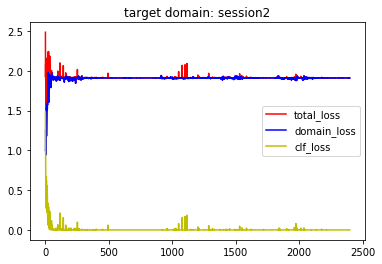

In [8]:
plt.plot(range(len(total_loss)),total_loss,c='r',label='total_loss')
plt.plot(d_loss,c='b',label='domain_loss')
plt.plot(c_loss,c='y',label='clf_loss')
plt.title('target domain: session2')
plt.legend(loc='best')
plt.show()

max target accuracy:  82.98257429076521


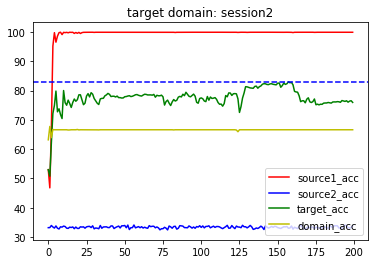

In [9]:
print('max target accuracy: ',max(acc_list3))
plt.plot(range(len(acc_list1)),acc_list1,c='r',label='source1_acc')
plt.plot(acc_list2,c='b',label='source2_acc')
plt.plot(acc_list3,c='g',label='target_acc')
plt.plot(acc_list4,c='y',label='domain_acc')
plt.axhline(max(acc_list3),c='b',linestyle='--')
plt.title('target domain: session2')
plt.legend(loc='best')
plt.show()